In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


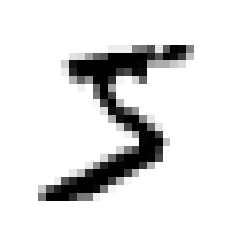

Label: 5


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
another_digit = X[1]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()
print('Label:', y[0])

In [4]:
import numpy as np
y = y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

# Training a Binary Classifier

In [7]:
# Let's create the target vector for this classification task
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) 

In [8]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit, another_digit])

array([ True, False])

# Performance Measures

## Measuring Accuracy Using Cross_Validation

### Implementing Cross-Validation

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=2, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.9550666666666666
0.9524


In [15]:
from sklearn.model_selection import  cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# With 95% of accuracy let's look at dumb classifier that just classifies every single image in the not 'not-5' class.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

**Precision:** For what fraction of ***positive predictions*** are *correct*

**Recall:** What fraction of ***positive instances*** does the the classifier correctly identify as *positive*.

In [16]:
from sklearn.metrics import precision_score, recall_score

print('Precision Score: ',precision_score(y_train_5, y_train_pred))
print('Recall Score:    ',recall_score(y_train_5, y_train_pred))

Precision Score:  0.8370879772350012
Recall Score:     0.6511713705958311


When it claims an image represents 5, it is correct only 83% of the time.

It only detects 65% of the 5s (Positive instances)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

In [18]:
# Changing the threshold using descision_function which returns a score of each instance
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([ True])

In [20]:
threshold = 8000
y_some_digit_prediction = (y_scores > threshold)
y_some_digit_prediction

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

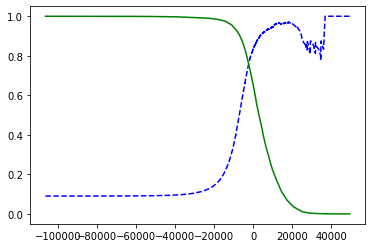

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    #[...] highlight the threshold and add the legend, axis label, and grid
 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

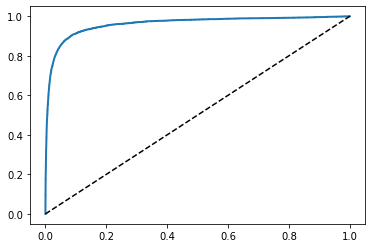

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    # [...] add asix labels and grid

plot_roc_curve(fpr, tpr)

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5 , y_scores)

0.9604938554008616

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

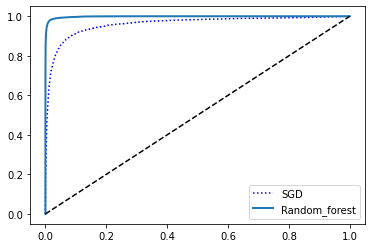

In [26]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random_forest')
plt.legend()
plt.show()

# Multiclass Classification

In [27]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [29]:
np.argmax(some_digit_scores)

5

In [30]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# If you want to force scikit-learn to use either OVR, OVO strategy
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
over_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [10]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [12]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [16]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

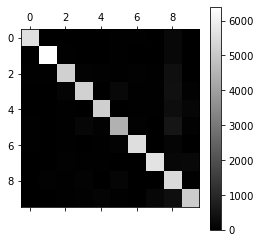

In [29]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.colorbar()

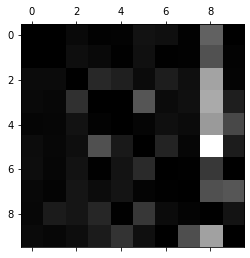

In [40]:
rows_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sum

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

NameError: name 'plot_digits' is not defined

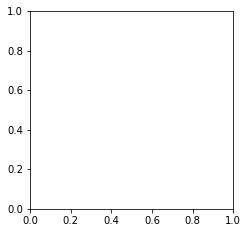

In [50]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)    
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

NameError: name 'f1_score' is not defined

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

In [ ]:
noise = np.random.randint(0, 100, (len(X_train, 784)))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
plot_digit(clean_digit)